In [ ]:
import datetime
import time

import urllib.request
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

def yahoo_finance_csv(code, start_from_date = '2010-07-01', end_to_date = datetime.date.today().isoformat(), interval = 'd'): #other intervals are 'wk' and 'mo'

    #setting an header to avoid possible errors
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-Agent','Mozilla/5.0')]
    urllib.request.install_opener(opener)
    
    #converting dates from iso format
    start_from_date = datetime.datetime.fromisoformat(start_from_date)
    end_to_date = datetime.datetime.fromisoformat(end_to_date)
    
    #converting dates to unix time
    start_from_code = int(time.mktime(start_from_date.timetuple())) #1277942400 is the code of the 1st of july of 2010 / CHOOSE A CLOSER DATE IF THE CHANGE IN PRICE LEVEL IS SUBSTANTIAL
    todays_code = int(time.mktime(end_to_date.timetuple()))

    url = f'https://query1.finance.yahoo.com/v7/finance/download/{code}?period1={start_from_code}&period2={todays_code}&interval=1{interval}&events=history&includeAdjustedClose=true'

    #Save as a temporary file and return the a (position, HTTP message)
    save_to_path = urllib.request.urlretrieve(url)
    
    pos_saved_csv = save_to_path[0]

    return pos_saved_csv

# DOWNLOADING AND PREPARATION THE DATA

In [ ]:
#DOWNLOAD the prices with {code}
code = 'BTC-EUR'
df = pd.read_csv(yahoo_finance_csv(code))

In [ ]:
#dropping null rows (sometimes yahoo finance has them)
df = df.dropna().reset_index(drop=True)

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,359.546204,361.468506,351.586884,355.957367,355.957367,16389166
1,2014-09-18,355.588409,355.505402,319.789459,328.539368,328.539368,26691849
2,2014-09-19,328.278503,330.936707,298.921021,307.761139,307.761139,29560103
3,2014-09-20,307.665253,329.978180,303.931244,318.758972,318.758972,28736826
4,2014-09-21,318.120514,321.504517,306.502197,310.632446,310.632446,20702625
...,...,...,...,...,...,...,...
2881,2022-08-07,22541.207031,22955.015625,22473.525391,22783.662109,22783.662109,15617948551
2882,2022-08-08,22787.236328,23732.878906,22792.974609,23347.226563,23347.226563,28020750644
2883,2022-08-09,23349.183594,23441.267578,22445.599609,22691.765625,22691.765625,23075182547
2884,2022-08-10,22690.375000,23377.703125,22313.289063,23252.611328,23252.611328,31884390941


In [ ]:
#splitting and Training and Test data
training_to_test_ratio = 0.7
split_val = round(len(df)*training_to_test_ratio)
print(split_val, 'on', len(df))

training_set = df.iloc[:split_val-1]
test_set = df.iloc[split_val:]

2020 on 2886


In [ ]:
#checking if it corresponds for applying it later in the resulting plot
pd.DatetimeIndex(df['Date']).year[np.arange(0, 2500, 500)]

Int64Index([2014, 2016, 2017, 2018, 2020], dtype='int64', name='Date')

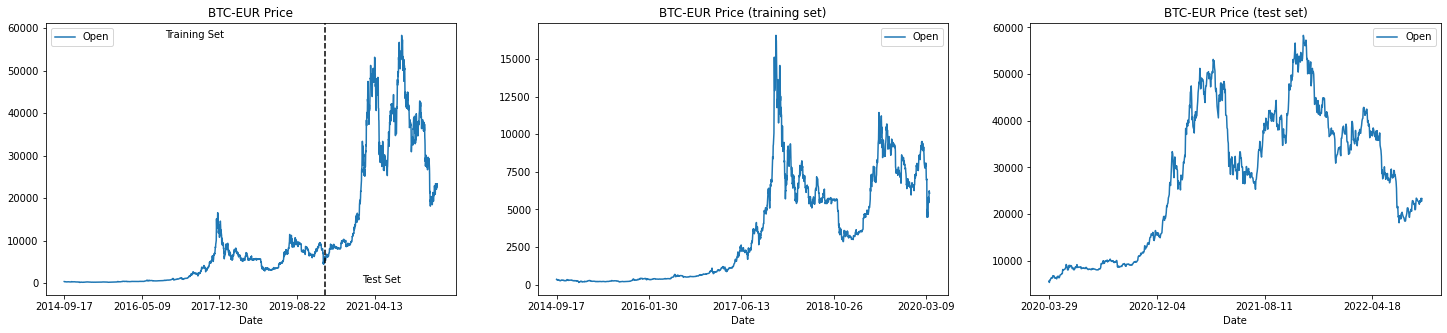

In [ ]:
#plotting training and test data
fig, axs = plt.subplots(1,3,figsize=(25,5))

df.plot(x='Date', y=['Open'], ax=axs[0], title=f'{code} Price', xticks=np.arange(0, len(df), 600))
training_set.plot(x='Date', y=['Open'], ax=axs[1], title=f'{code} Price (training set)', xticks=np.arange(0, len(training_set), 500))
test_set.plot(x='Date', y=['Open'], ax=axs[2], title=f'{code} Price (test set)', xticks=np.arange(0, len(test_set), 250))

axs[0].axvline(split_val, c='k', linestyle='--') 
axs[0].text(round(split_val/2), df['Open'].max()*0.99, s='Training Set', horizontalalignment='center')
axs[0].text(round((split_val+len(df))/2), df['Open'].min(), s='Test Set', horizontalalignment='center')
plt.show()

In [ ]:
#scaling the training set
scale = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = scale.fit_transform(training_set.values[:,1].reshape(-1,1))

In [ ]:
#building the training data sequences from the original data

X_train = []
y_train = []

time_stamps = 30 #for each record there will be that number of time stamps
days = 1 #1 = next day, predict the value there will be in the next number of days

#example (time stamps 30, days 2):
#the previous month will be consider to predict the value in the next 2nd day
days_forward = days-1 #for coding purposes 0 is 1 day forward, 1 is two day forward

for i in range(time_stamps, split_val-1-days_forward):
    X_train.append(X_train_scaled[i-time_stamps:i, 0])
    y_train.append(X_train_scaled[i+days_forward, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
#Check the outlook of the sequence
X_train_scaled[0:time_stamps, 0]

array([0.01275208, 0.01251108, 0.01084809, 0.00959288, 0.01022954,
       0.0097868 , 0.00991238, 0.01151062, 0.0110267 , 0.01050005,
       0.01023509, 0.01003894, 0.00896653, 0.00890624, 0.00954019,
       0.00938463, 0.00889113, 0.00836913, 0.00686196, 0.0064508 ,
       0.00678027, 0.00702242, 0.00771841, 0.00836187, 0.00828608,
       0.00834608, 0.00906595, 0.00960925, 0.01017264, 0.00959721])

In [ ]:
#it should be the same as before
X_train[0].ravel()

array([0.01275208, 0.01251108, 0.01084809, 0.00959288, 0.01022954,
       0.0097868 , 0.00991238, 0.01151062, 0.0110267 , 0.01050005,
       0.01023509, 0.01003894, 0.00896653, 0.00890624, 0.00954019,
       0.00938463, 0.00889113, 0.00836913, 0.00686196, 0.0064508 ,
       0.00678027, 0.00702242, 0.00771841, 0.00836187, 0.00828608,
       0.00834608, 0.00906595, 0.00960925, 0.01017264, 0.00959721])

In [ ]:
#The training sequence is until the time_stamps, the target is the last element days_forward
X_train_scaled[0:time_stamps+days_forward+1, 0]

array([0.01275208, 0.01251108, 0.01084809, 0.00959288, 0.01022954,
       0.0097868 , 0.00991238, 0.01151062, 0.0110267 , 0.01050005,
       0.01023509, 0.01003894, 0.00896653, 0.00890624, 0.00954019,
       0.00938463, 0.00889113, 0.00836913, 0.00686196, 0.0064508 ,
       0.00678027, 0.00702242, 0.00771841, 0.00836187, 0.00828608,
       0.00834608, 0.00906595, 0.00960925, 0.01017264, 0.00959721,
       0.00906268])

In [ ]:
#check if the target corresponds for the time_stamp sequence
X_train_scaled[time_stamps+days_forward]

array([0.00906268])

In [ ]:
#it should be the same as before
y_train[0]

0.009062676067257507

In [ ]:
#reshaping the training set for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# BUILDING THE MODEL

In [ ]:
n_epochs = 15 #considering the average resulting loss it's not that better usually an higher n°
n_layers = 4

In [ ]:
n_layers -= 1
#initialising the model
model = Sequential()

#adding n° LSTM layers
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_stamps, 1)))
model.add(Dropout(0.2))
for i in range(n_layers):
    if i < (n_layers-1):
        return_sequences = True
    else:
        return_sequences = False
    model.add(LSTM(units = 50, return_sequences = return_sequences))
    model.add(Dropout(0.2))

#adding the output dense layer
model.add(Dense(units = 1))

#cmpiling the model with adam and mse
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
#training on the training data
model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)

Epoch 1/15
63/63 [==============================] - 19s 65ms/step - loss: 0.0116
Epoch 2/15
63/63 [==============================] - 4s 70ms/step - loss: 0.0035
Epoch 3/15
63/63 [==============================] - 4s 65ms/step - loss: 0.0028
Epoch 4/15
63/63 [==============================] - 4s 65ms/step - loss: 0.0028
Epoch 5/15
63/63 [==============================] - 4s 66ms/step - loss: 0.0027
Epoch 6/15
63/63 [==============================] - 4s 65ms/step - loss: 0.0021
Epoch 7/15
63/63 [==============================] - 4s 64ms/step - loss: 0.0021
Epoch 8/15
63/63 [==============================] - 4s 64ms/step - loss: 0.0020
Epoch 9/15
63/63 [==============================] - 4s 64ms/step - loss: 0.0020
Epoch 10/15
63/63 [==============================] - 4s 65ms/step - loss: 0.0017
Epoch 11/15
63/63 [==============================] - 4s 66ms/step - loss: 0.0018
Epoch 12/15
63/63 [==============================] - 4s 65ms/step - loss: 0.0019
Epoch 13/15
63/63 [=================

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

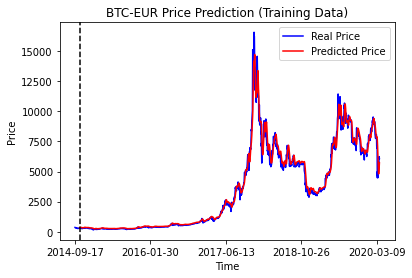

In [ ]:
#checking the results of prediction on the training set
moving_horizontally = np.arange(time_stamps, len(training_set)-days_forward)
train_prediction = scale.inverse_transform(model.predict(X_train))

plt.plot(training_set.values[:,1], color = 'blue', label = 'Real Price')
plt.plot(moving_horizontally, train_prediction, color = 'red', label = 'Predicted Price')
plt.title(f'{code} Price Prediction (Training Data)')
plt.xlabel('Time')
plt.ylabel('Price')

ticks_freq = 500
plt.xticks(np.arange(0, len(training_set), ticks_freq), training_set['Date'][np.arange(training_set.index[0], training_set.index[-1], ticks_freq)])

#here the prediction starts later because of the time stamp selected needed for previous predictions
plt.axvline(time_stamps, c='k', linestyle='--') 
plt.legend()
plt.show()

In [ ]:
#getting the test set in the same format of the training (meaning a sequence composed of n° of time_stamps)
to_test = pd.concat((training_set[-time_stamps:], test_set))['Open'].values
to_test = to_test.reshape(-1,1)
to_test = scale.transform(to_test)

X_test = []
for i in range(time_stamps, len(test_set)+time_stamps):
    X_test.append(to_test[i-time_stamps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#rescaling the data
y_pred = model.predict(X_test)
test_predictions = scale.inverse_transform(y_pred)

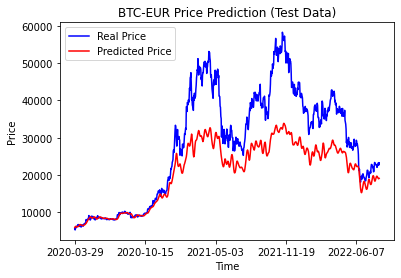

In [ ]:
#plotting the results
plt.plot(test_set.values[:,1], color = 'blue', label = 'Real Price')
plt.plot(test_predictions, color = 'red', label = 'Predicted Price')
plt.title(f'{code} Price Prediction (Test Data)')
plt.xlabel('Time')
plt.ylabel('Price')

ticks_freq = 200
plt.xticks(np.arange(0, len(test_set), ticks_freq), test_set['Date'][np.arange(test_set.index[0], test_set.index[-1], ticks_freq)])
plt.legend()
plt.show()

# Extra: Testing Rolling predictions

In [ ]:
#It's useless as it should be possible to access the data day by day
#but I did it as it is usefull to understand the underlying mechanism with certain sequences

#I needed to set the first sequence of n° time_stamps
first_sequence = X_test[0].reshape(1,time_stamps,1) #reshaping to the format needed by the model

#defining a function that gives a list of subsequent preidction of the same length of the first sequence
def predict_next(first_sequence, model = model):
    rolling = [x for x in first_sequence.ravel()]
    prediction_sequence = []

    for x in range(0, len(rolling)):
        sequence_to_use = rolling[x:]+prediction_sequence
        sequence_to_use = np.array(sequence_to_use).reshape(1,time_stamps,1)
        predicted_value = model.predict(sequence_to_use)[0][0]
        prediction_sequence.append(predicted_value)
      
    return prediction_sequence

#defining a function that loop over the previous one to give me the complete sequence
def predict_long(first_sequence, loop = 3): #if the length of first sequence is 30, then loop 3 is around three months
    grand_sequence = []
    
    sequence_to_use = first_sequence

    for i in range(loop):
        grand_sequence.append(predict_next(sequence_to_use))
        sequence_to_use = np.array(grand_sequence[i]).reshape(1,time_stamps,1)

    return grand_sequence

In [ ]:
import itertools

grand_sequence = predict_long(first_sequence, loop = 25)
delist = list(itertools.chain.from_iterable(grand_sequence))
predicted_grand_sequence = scale.inverse_transform(np.array(delist).reshape(-1,1)).ravel()

In [ ]:
print('test_set:', len(test_set), '\nlist_to_plot:', len(predicted_grand_sequence))

test_set: 866 
list_to_plot: 750


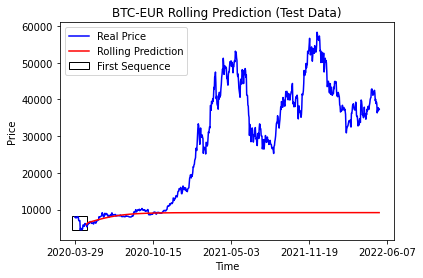

In [ ]:
import matplotlib.patches as patches

#Plotting the results
fig, ax = plt.subplots()

horizontal_shift = np.arange(time_stamps, time_stamps+len(predicted_grand_sequence))
slice_origin = slice(split_val-time_stamps, split_val+len(predicted_grand_sequence))
real_grand_sequence = df['Open'].values[slice_origin]

ax.plot(real_grand_sequence, color = 'blue', label = 'Real Price')
ax.plot(horizontal_shift, predicted_grand_sequence, color = 'red', label = 'Rolling Prediction')
ax.set_title(f'{code} Rolling Prediction (Test Data)')
ax.set_xlabel('Time')
ax.set_ylabel('Price')

ticks_freq = 200
ax.set_xticks(np.arange(0, len(test_set), ticks_freq))
ax.set_xticklabels(test_set['Date'][np.arange(test_set.index[0], test_set.index[-1], ticks_freq)])

#Here I created a rectangle comprising the first original (blue) sequence from which the rolling prediction came
first_original = real_grand_sequence[:time_stamps] #the data to surround
xpos = -len(real_grand_sequence)*0.01 #positioning 1% earlier than the first value to not be too tight
ypos = first_original.min()*0.99
width = time_stamps-xpos #it's not precise on a large scale thus I enlarge it by 1%
height = first_original.max()*1.01-ypos

#Adding the rectangle
rect = patches.Rectangle((xpos, ypos), width, height, linewidth=1, edgecolor='k', facecolor='none', label = 'First Sequence')
ax.add_patch(rect)

plt.legend()
plt.show()

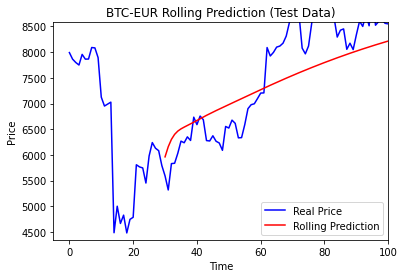

In [ ]:
import matplotlib.patches as patches

#Plotting the results
fig, ax = plt.subplots()

horizontal_shift = np.arange(time_stamps, time_stamps+len(predicted_grand_sequence))
slice_origin = slice(split_val-time_stamps, split_val+len(predicted_grand_sequence))
real_grand_sequence = df['Open'].values[slice_origin]

ax.plot(real_grand_sequence, color = 'blue', label = 'Real Price')
ax.plot(horizontal_shift, predicted_grand_sequence, color = 'red', label = 'Rolling Prediction')
ax.set_title(f'{code} Rolling Prediction (Test Data)')
ax.set_xlabel('Time')
ax.set_ylabel('Price')

#Here I created a rectangle comprising the first original (blue) sequence from which the rolling prediction came
first_original = real_grand_sequence[:30] #the data to surround
xpos = -len(real_grand_sequence)*0.01 #positioning 1% earlier than the first value to not be too tight
ypos = first_original.min()*0.99
width = time_stamps-xpos #it's not precise on a large scale thus I enlarge it by 1%
height = first_original.max()*1.01-ypos
plt.xlim(-5, 100)
plt.ylim(ypos*0.98, (height+ypos)*1.05)

plt.legend()
plt.show()

Conclusion: without constant update of the data upon to predict the prediction will probably (without retraining on the days_forward) predict along a curve of an activation function built initially upon the optimization of patterns similar to the time_stamps of training similar to the first sequence and then rolling along the last value with probably an identical output of the activation function